In [ ]:
# Step 1: Mount Google Drive (only needed if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 2: Import Libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

Initial Data Snapshot:
   id                      car_name         brand car_model  model_year  \
0   1  MarutiSuzukiWagonRUttara2012  MarutiSuzuki    WagonR        2012   
1   2               ToyotaHiace2005        Toyota     Hiace        2005   
2   3                ToyotaAxio2009        Toyota      Axio        2009   
3   4               ToyotaCorsa1999        Toyota     Corsa        1999   
4   5             ToyotaCorolla2002        Toyota   Corolla        2002   

  transmission  body_type fuel_type  engine_capacity   travels      price  \
0    Automatic  Hatchback    Octane             1500   60000.0  2550000.0   
1    Automatic        MPV       CNG             2000   32000.0  2000200.0   
2    Automatic  Hatchback       CNG             1500   25500.0  2245550.0   
3    Automatic  Hatchback       CNG             1500   90000.0  1120000.0   
4    Automatic      Sedan       CNG             1500  202580.0  2320025.0   

  accident   registration  
0         N          2025  
1      

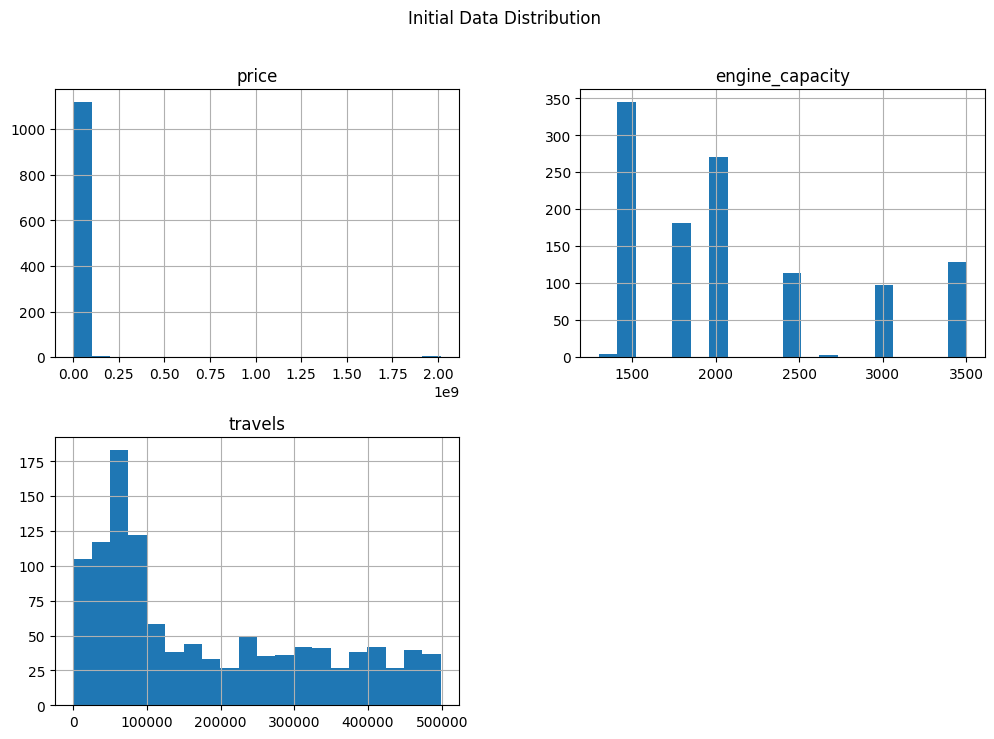

In [ ]:
# Step 3: Load the Dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/colltected_final.csv'
car_df = pd.read_csv(file_path, encoding='latin-1')

# Step 4: Display Initial Data
print("Initial Data Snapshot:")
print(car_df.head())
print("\nData Summary:")
print(car_df.info())

# Plot histogram of initial data for selected columns
car_df[['price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Initial Data Distribution")
plt.show()

<ipython-input-4-637b4078bad1>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df[col].fillna(car_df[col].mode()[0], inplace=True)
<ipython-input-4-637b4078bad1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df[col].fillna(car_df[col].mode()[0], inplace=True)
<ipython-input-4-637b4078bad1>:12: SettingWithCopyWarning: 
A value is tr

Data Shape after Cleaning: (1127, 13)


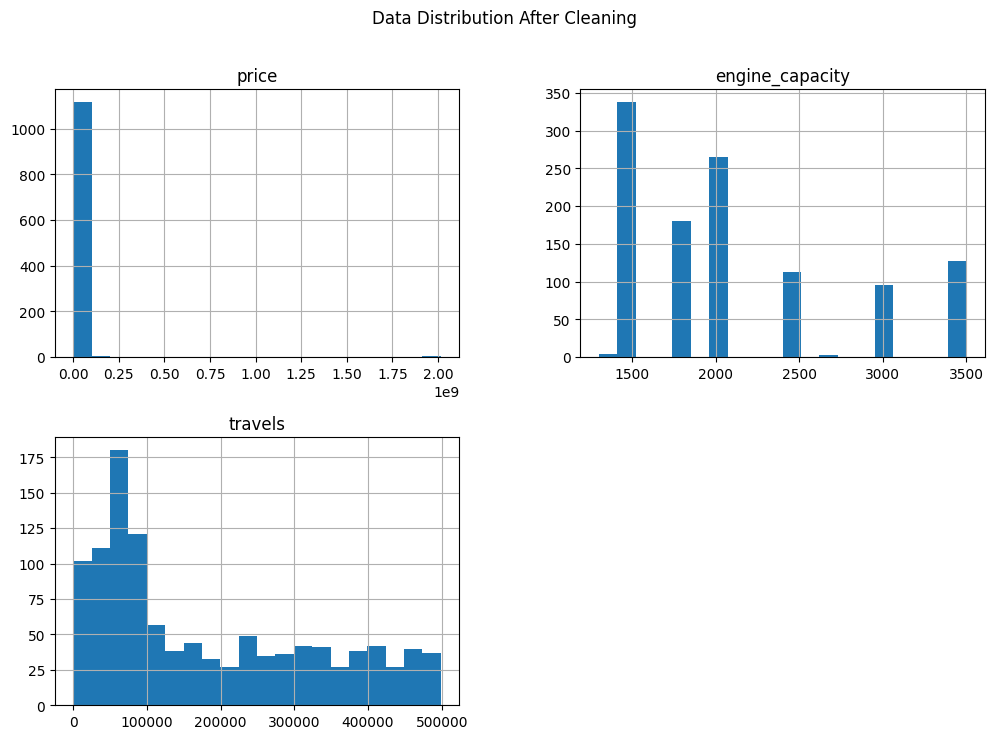

In [ ]:
# Handling Missing Values
car_df.isna().sum()  # Check missing values

# Drop rows with more than 5% missing values
car_df = car_df.dropna(thresh=len(car_df.columns) * 0.95)

# Fill categorical missing values with the most frequent category
for col in ['body_type', 'fuel_type']:
    car_df[col].fillna(car_df[col].mode()[0], inplace=True)

# Check and remove duplicates
car_df.drop_duplicates(keep='first', inplace=True)

# Verify final shape after preprocessing
print("Data Shape after Cleaning:", car_df.shape)

# Plot histogram after cleaning
car_df[['price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Data Distribution After Cleaning")
plt.show()


Processed Data Snapshot:
   id                      car_name         brand fuel_type  engine_capacity  \
0   1  MarutiSuzukiWagonRUttara2012  MarutiSuzuki    Octane             1500   
1   2               ToyotaHiace2005        Toyota       CNG             2000   
2   3                ToyotaAxio2009        Toyota       CNG             1500   
3   4               ToyotaCorsa1999        Toyota       CNG             1500   
4   5             ToyotaCorolla2002        Toyota       CNG             1500   

    travels      price  age age_category price_category  \
0   60000.0  2550000.0   12     Very Old            Low   
1   32000.0  2000200.0   19     Very Old            Low   
2   25500.0  2245550.0   15     Very Old            Low   
3   90000.0  1120000.0   25     Very Old            Low   
4  202580.0  2320025.0   22     Very Old            Low   

  engine_capacity_category travels_category  
0                   Medium           Medium  
1                     High              Low  
2

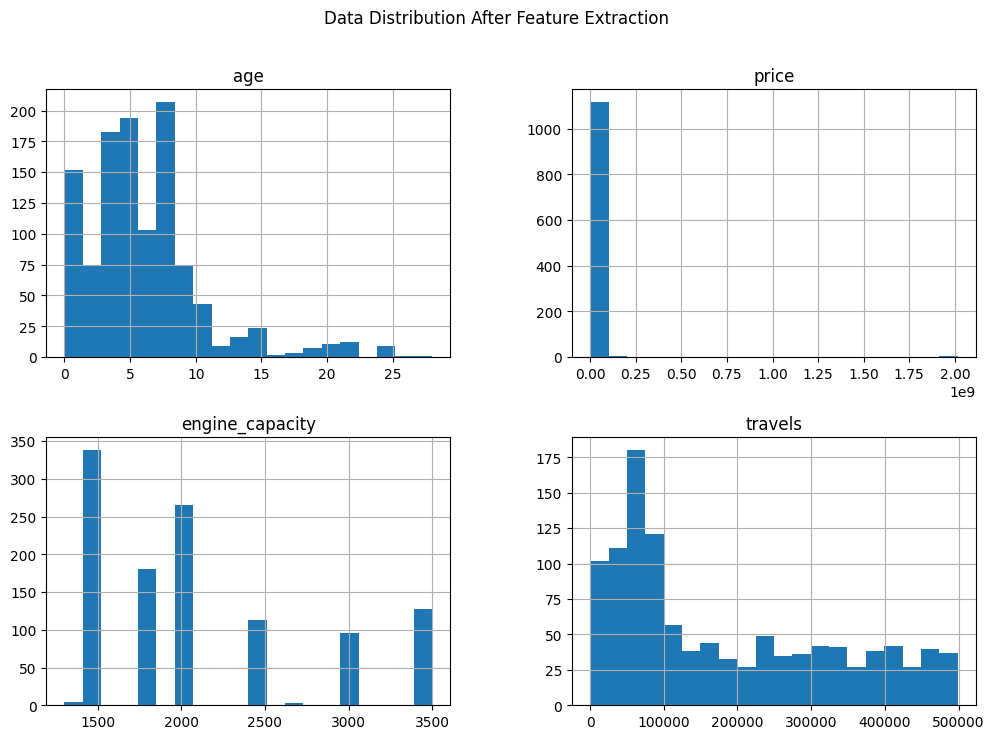

In [ ]:
from datetime import datetime

# Current year for calculating car age
current_year = datetime.now().year

# Feature Extraction Function
def preprocess_and_extract_features(df):
    # Calculate car age
    df['age'] = current_year - df['model_year']

    # Add Age Category
    age_bins = [0, 2, 5, 10, float('inf')]
    age_labels = ['New', 'Recent', 'Old', 'Very Old']
    df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

    # Add Price Category
    price_bins = [0, df['price'].quantile(0.33), df['price'].quantile(0.66), df['price'].max()]
    df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=['Low', 'Medium', 'High'])

    # Add Engine Capacity Category
    engine_bins = [0, 1499, 1799, float('inf')]
    df['engine_capacity_category'] = pd.cut(df['engine_capacity'], bins=engine_bins, labels=['Low', 'Medium', 'High'])

    # Add Travels Category
    travels_bins = [-1, 50000, 150000, float('inf')]
    travels_labels = ['Low', 'Medium', 'High']
    df['travels_category'] = pd.cut(df['travels'], bins=travels_bins, labels=travels_labels)


    # Drop columns not needed after extraction
    df = df.drop(columns=['transmission', 'body_type',  'car_model', 'model_year', 'accident ', 'registration'])

    return df

# Apply Feature Extraction
processed_df = preprocess_and_extract_features(car_df)
print("Processed Data Snapshot:")
print(processed_df.head())

# Plot histogram after feature extraction
processed_df[['age', 'price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Data Distribution After Feature Extraction")
plt.show()


TF-IDF Matrix (Dense Representation):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
TF-IDF Matrix Shape: (1127, 514)
Cosine Similarity Matrix:
[[1.         0.10540175 0.17533138 ... 0.13569711 0.20071854 0.20071854]
 [0.10540175 1.         0.21123314 ... 0.02395222 0.         0.        ]
 [0.17533138 0.21123314 1.         ... 0.06798684 0.10056381 0.10056381]
 ...
 [0.13569711 0.02395222 0.06798684 ... 1.         0.20378486 0.20378486]
 [0.20071854 0.         0.10056381 ... 0.20378486 1.         1.        ]
 [0.20071854 0.         0.10056381 ... 0.20378486 1.         1.        ]]
Cosine Similarity Matrix Shape: (1127, 1127)
Flattened Similarity Scores:
[1.         0.10540175 0.17533138 ... 0.20378486 1.         1.        ]


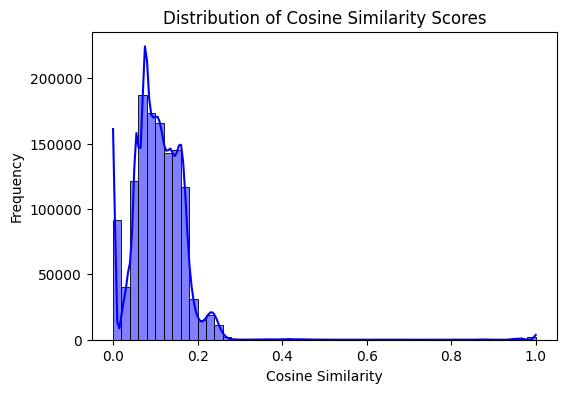

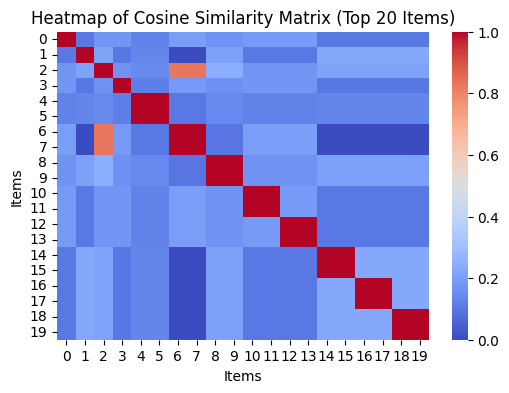

In [ ]:
# Combine Features for TF-IDF Vectorization
processed_df['combined_features'] = processed_df['car_name'] + ' ' + \
                                    processed_df['price_category'].astype(str) + ' ' + \
                                    processed_df['engine_capacity_category'].astype(str) + ' ' + \
                                    processed_df['travels_category'].astype(str)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_features'])

# Print the TF-IDF Matrix as an array
print("TF-IDF Matrix (Dense Representation):")
print(tfidf_matrix.toarray())  # Convert sparse matrix to dense for inspection

# Print the shape of the TF-IDF Matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the Cosine Similarity Matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)


# Compute Cosine Similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
print("Cosine Similarity Matrix Shape:", similarity_matrix.shape)

# Flatten the similarity matrix to a 1D array
similarity_scores = similarity_matrix.flatten()
print("Flattened Similarity Scores:")
print(similarity_scores)

# Plot distribution of similarity scores
plt.figure(figsize=(6, 4))
sns.histplot(similarity_scores, kde=True, bins=50, color='blue')
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the cosine similarity matrix
plt.figure(figsize=(6, 4))
sns.heatmap(similarity_matrix[:20, :20], cmap='coolwarm', annot=False)  # Limiting to first 20 items for clarity
plt.title("Heatmap of Cosine Similarity Matrix (Top 20 Items)")
plt.xlabel("Items")
plt.ylabel("Items")
plt.show()


Enter your preferred maximum price: 2000000
Enter preferred maximum age of the car: 10
Enter maximum kilometers traveled: 150000
Enter preferred minimum engine capacity (cc): 2500
Average Similarity Score (Accuracy): 27.09%


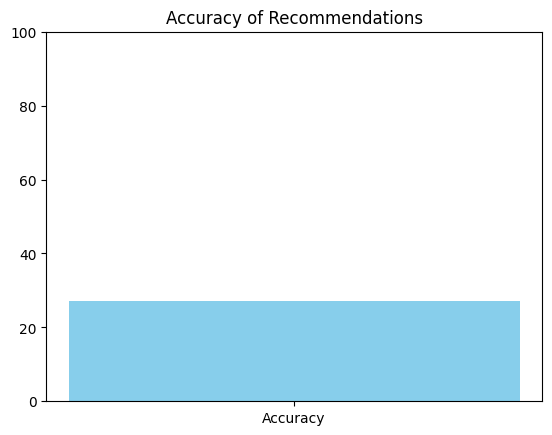

Recommendations Based on Buyer Preferences:
      id               car_name      price  engine_capacity  age
559  562        NissanRogue2016  1351295.0             2500    8
779  782         BMW5Series2016  1616458.0             3000    8
377  380  MitsubishiEclipse2018   910277.0             2500    6
795  798      MitsubishiASX2024  1884091.0             3500    0
411  414       NissanMurano2017  1896646.0             2500    7


In [ ]:
# Function to Get Buyer Preferences
def get_buyer_preferences():
    price = int(input("Enter your preferred maximum price: "))
    age = int(input("Enter preferred maximum age of the car: "))
    travels = int(input("Enter maximum kilometers traveled: "))
    engine_capacity = int(input("Enter preferred minimum engine capacity (cc): "))

    return {'price': price, 'age': age, 'travels': travels, 'engine_capacity': engine_capacity}


# Recommendation Function
def recommend_cars(df, similarity_matrix, buyer_preferences, top_n=5):
    # Filter the DataFrame based on buyer preferences
    filtered_cars = df[(df['price'] <= buyer_preferences['price']) &
                       (df['age'] <= buyer_preferences['age']) &
                       (df['travels'] <= buyer_preferences['travels']) &
                       (df['engine_capacity'] >= buyer_preferences['engine_capacity'])]

    if filtered_cars.empty:
        print("No cars match the buyer's preferences.")
        return None

    # Get the filtered indices in terms of zero-based similarity matrix
    filtered_indices = filtered_cars.index.tolist()

    # Subset similarity_matrix only on those cars
    avg_similarity_scores = similarity_matrix[filtered_indices].mean(axis=0)

    # Get top N cars based on similarity
    similar_cars_indices = avg_similarity_scores.argsort()[::-1][:top_n]

    # Handle case if index mismatch exists
    recommended_cars = df.iloc[similar_cars_indices]

    # Calculate accuracy (Average similarity score)
    avg_similarity_score = avg_similarity_scores[similar_cars_indices].mean()
    accuracy = avg_similarity_score * 100
    print(f"Average Similarity Score (Accuracy): {accuracy:.2f}%")

    # Plot accuracy
    plt.figure()
    plt.bar(["Accuracy"], [accuracy], color='skyblue')
    plt.ylim(0, 100)
    plt.title("Accuracy of Recommendations")
    plt.show()

    return recommended_cars[['id','car_name', 'price', 'engine_capacity', 'age']]


# Fix Index Alignment in DataFrame if needed
if 'id' in processed_df.columns:
    processed_df = processed_df.reset_index(drop=True)

# Get Buyer Preferences and Generate Recommendations
buyer_preferences = get_buyer_preferences()
recommendations = recommend_cars(processed_df, similarity_matrix, buyer_preferences)

if recommendations is not None:
    print("Recommendations Based on Buyer Preferences:")
    print(recommendations)
